# MLP's Failure

## 1. Locality Destruction

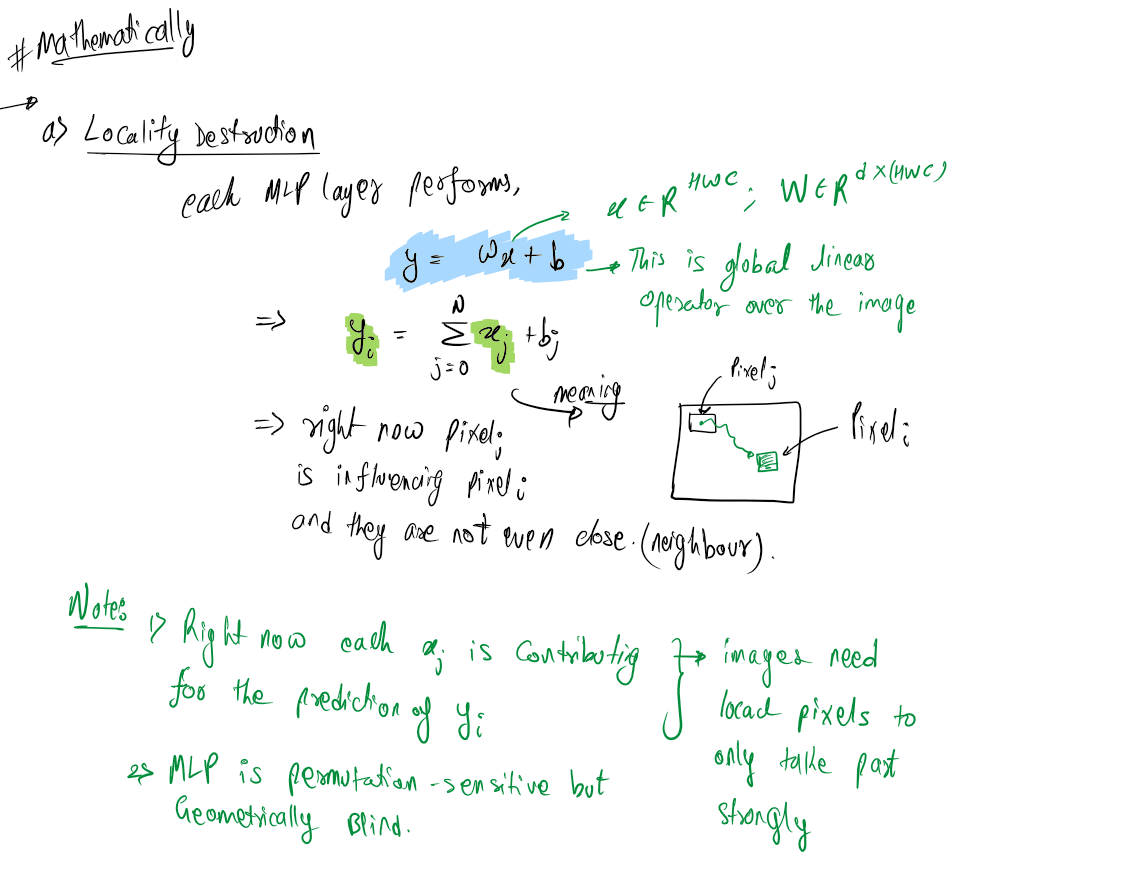

## No Parameter Sharing

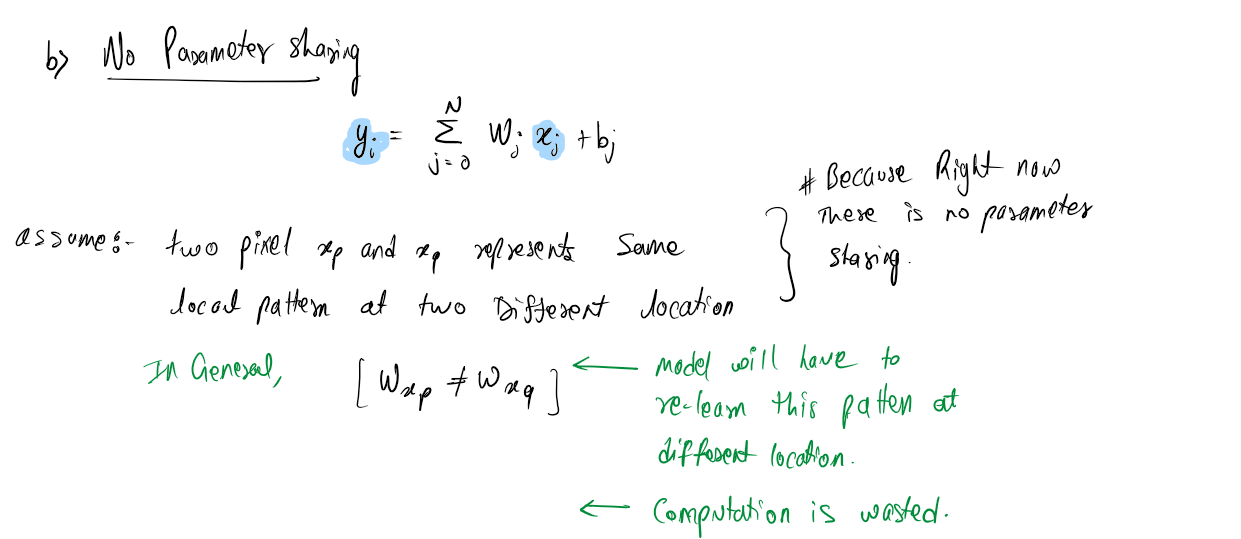

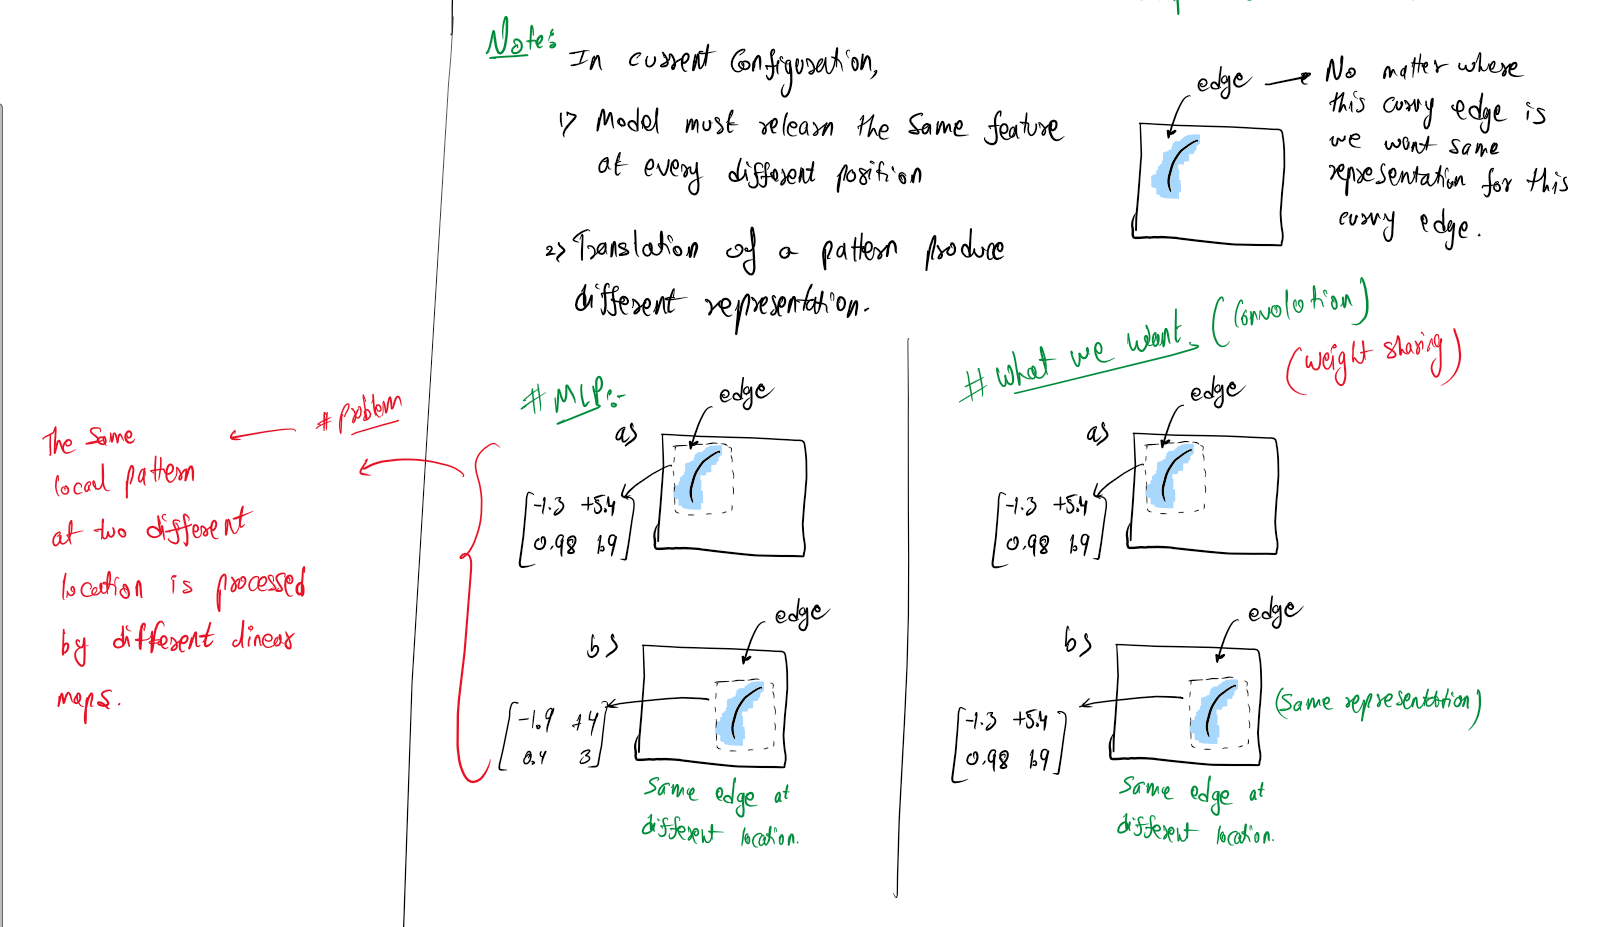

## Parameter Explosion

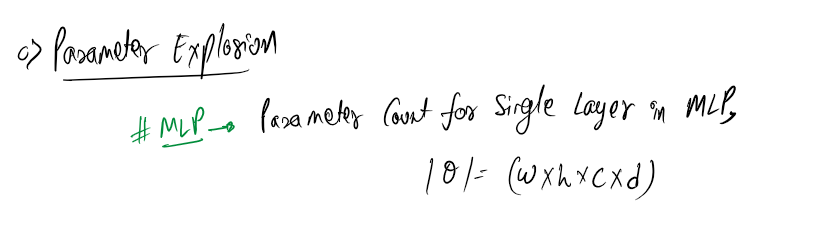

## Adding Constrains to MLP's Base Equation

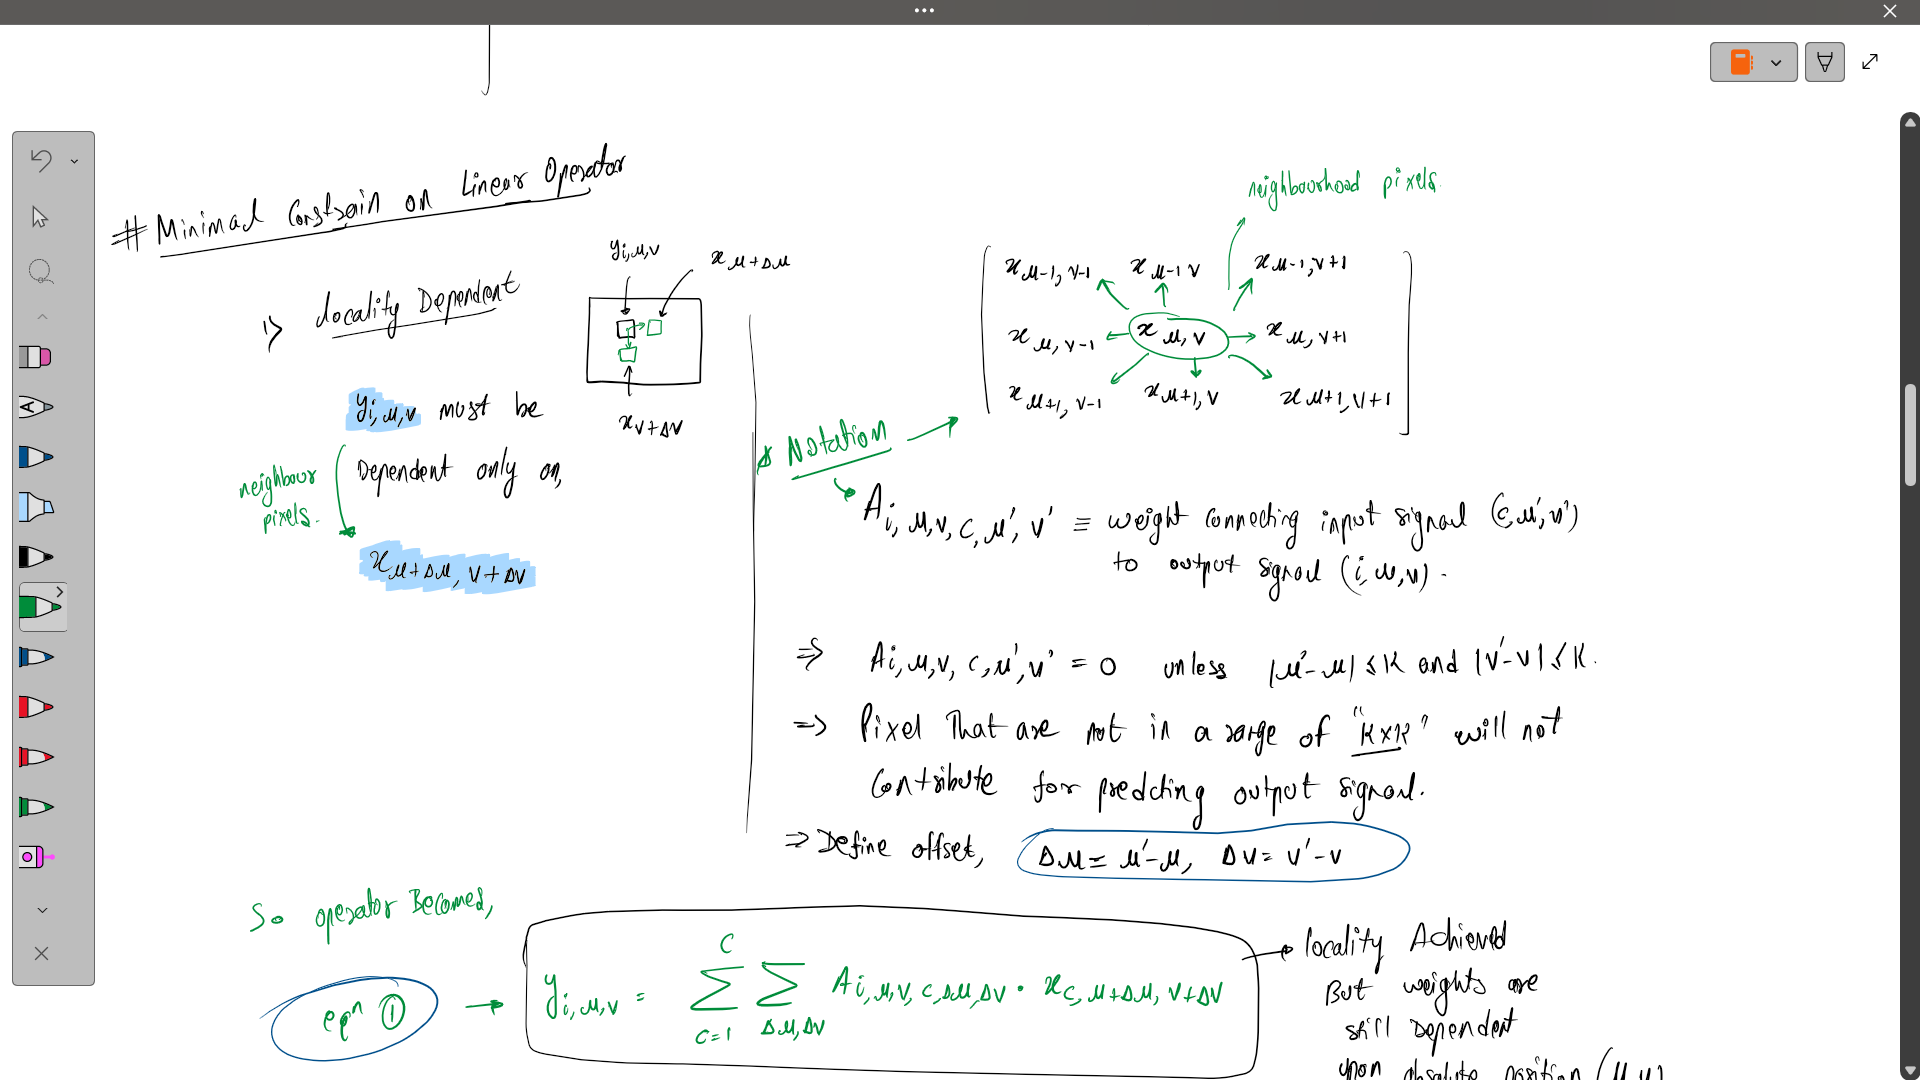

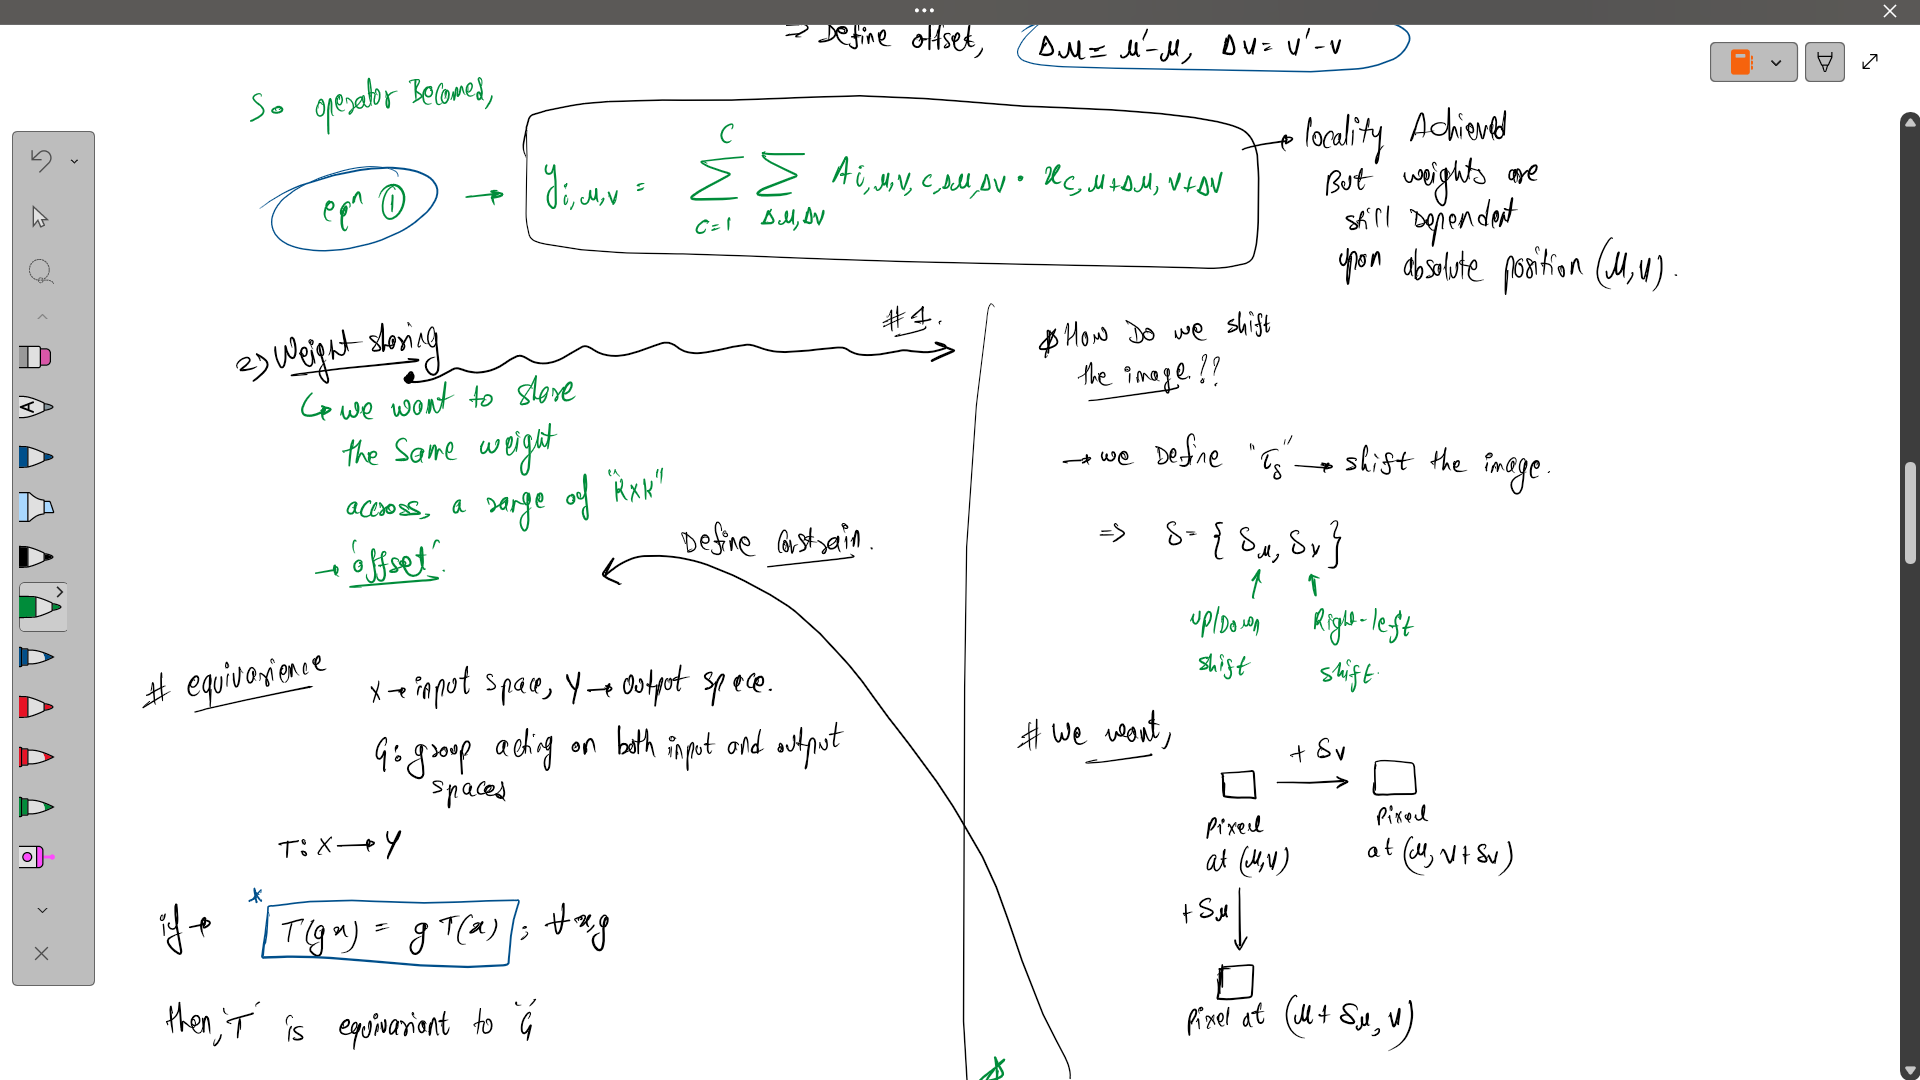

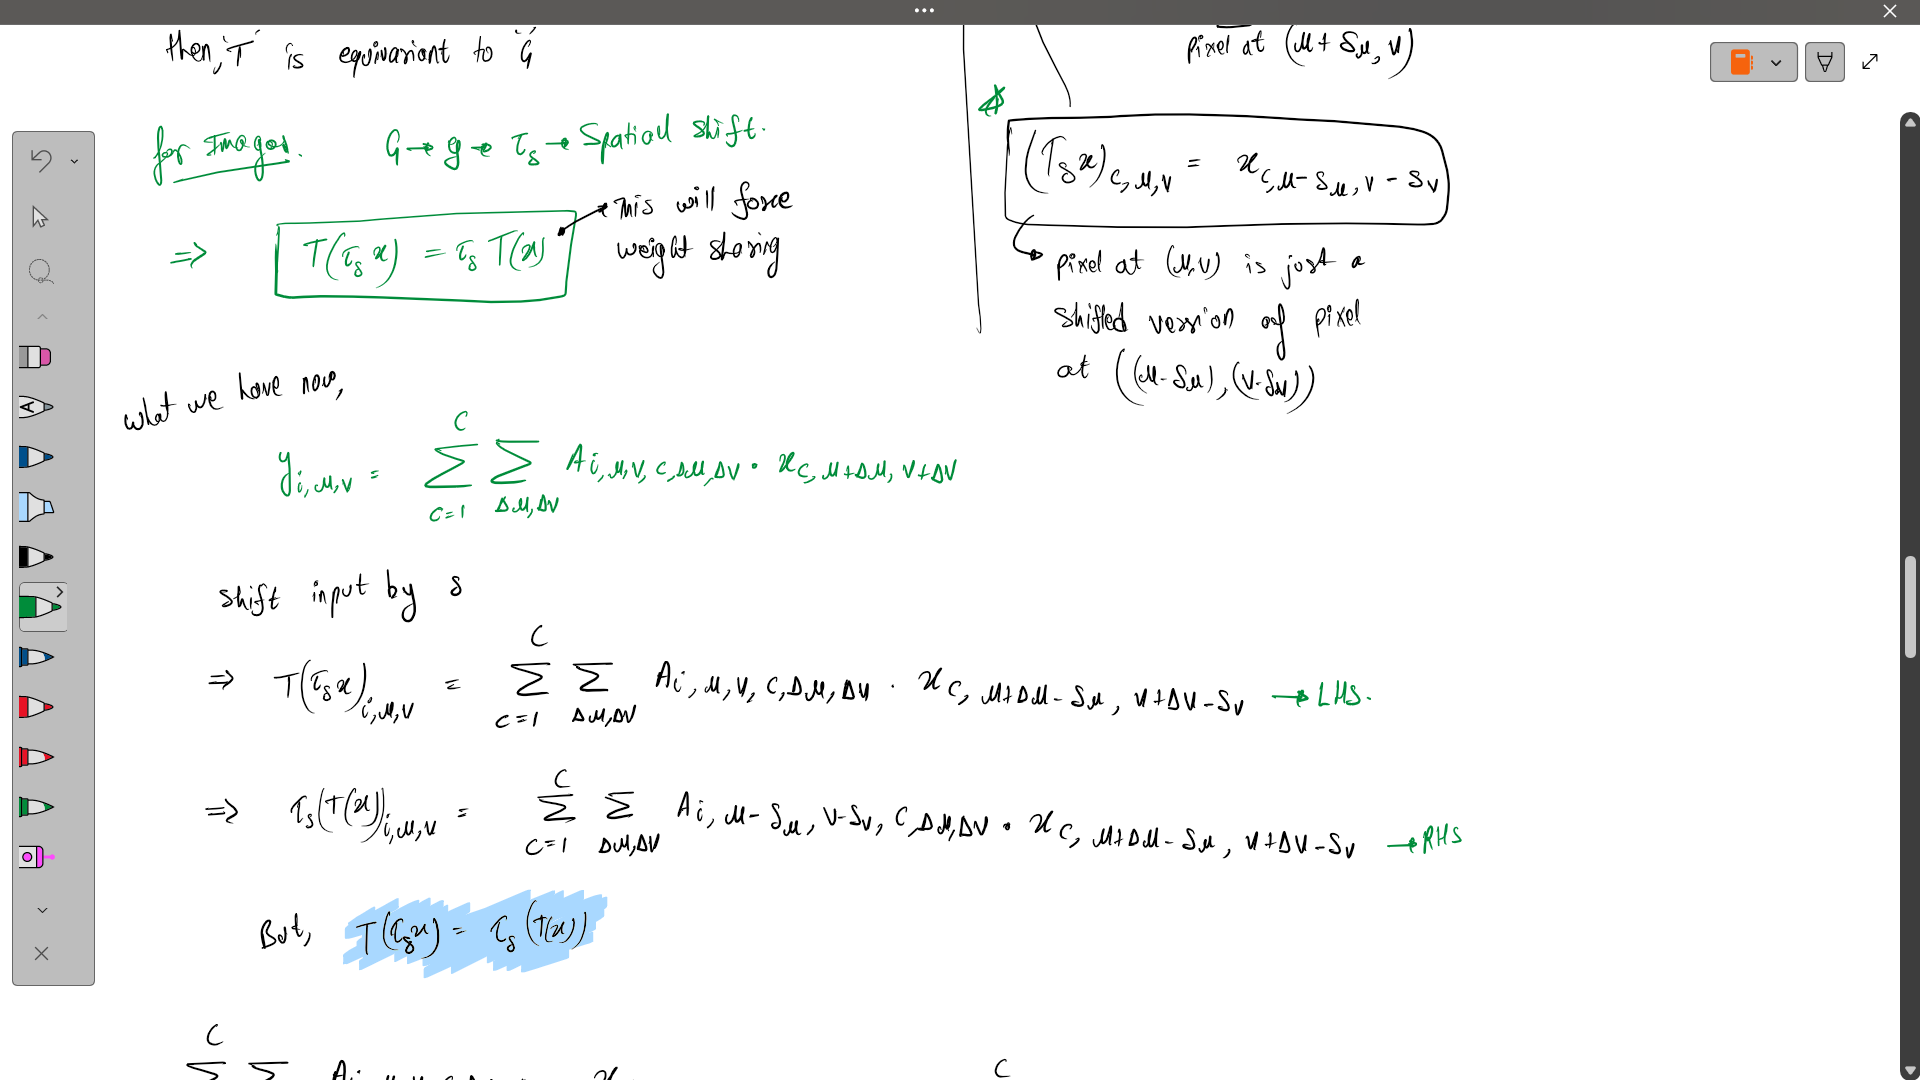

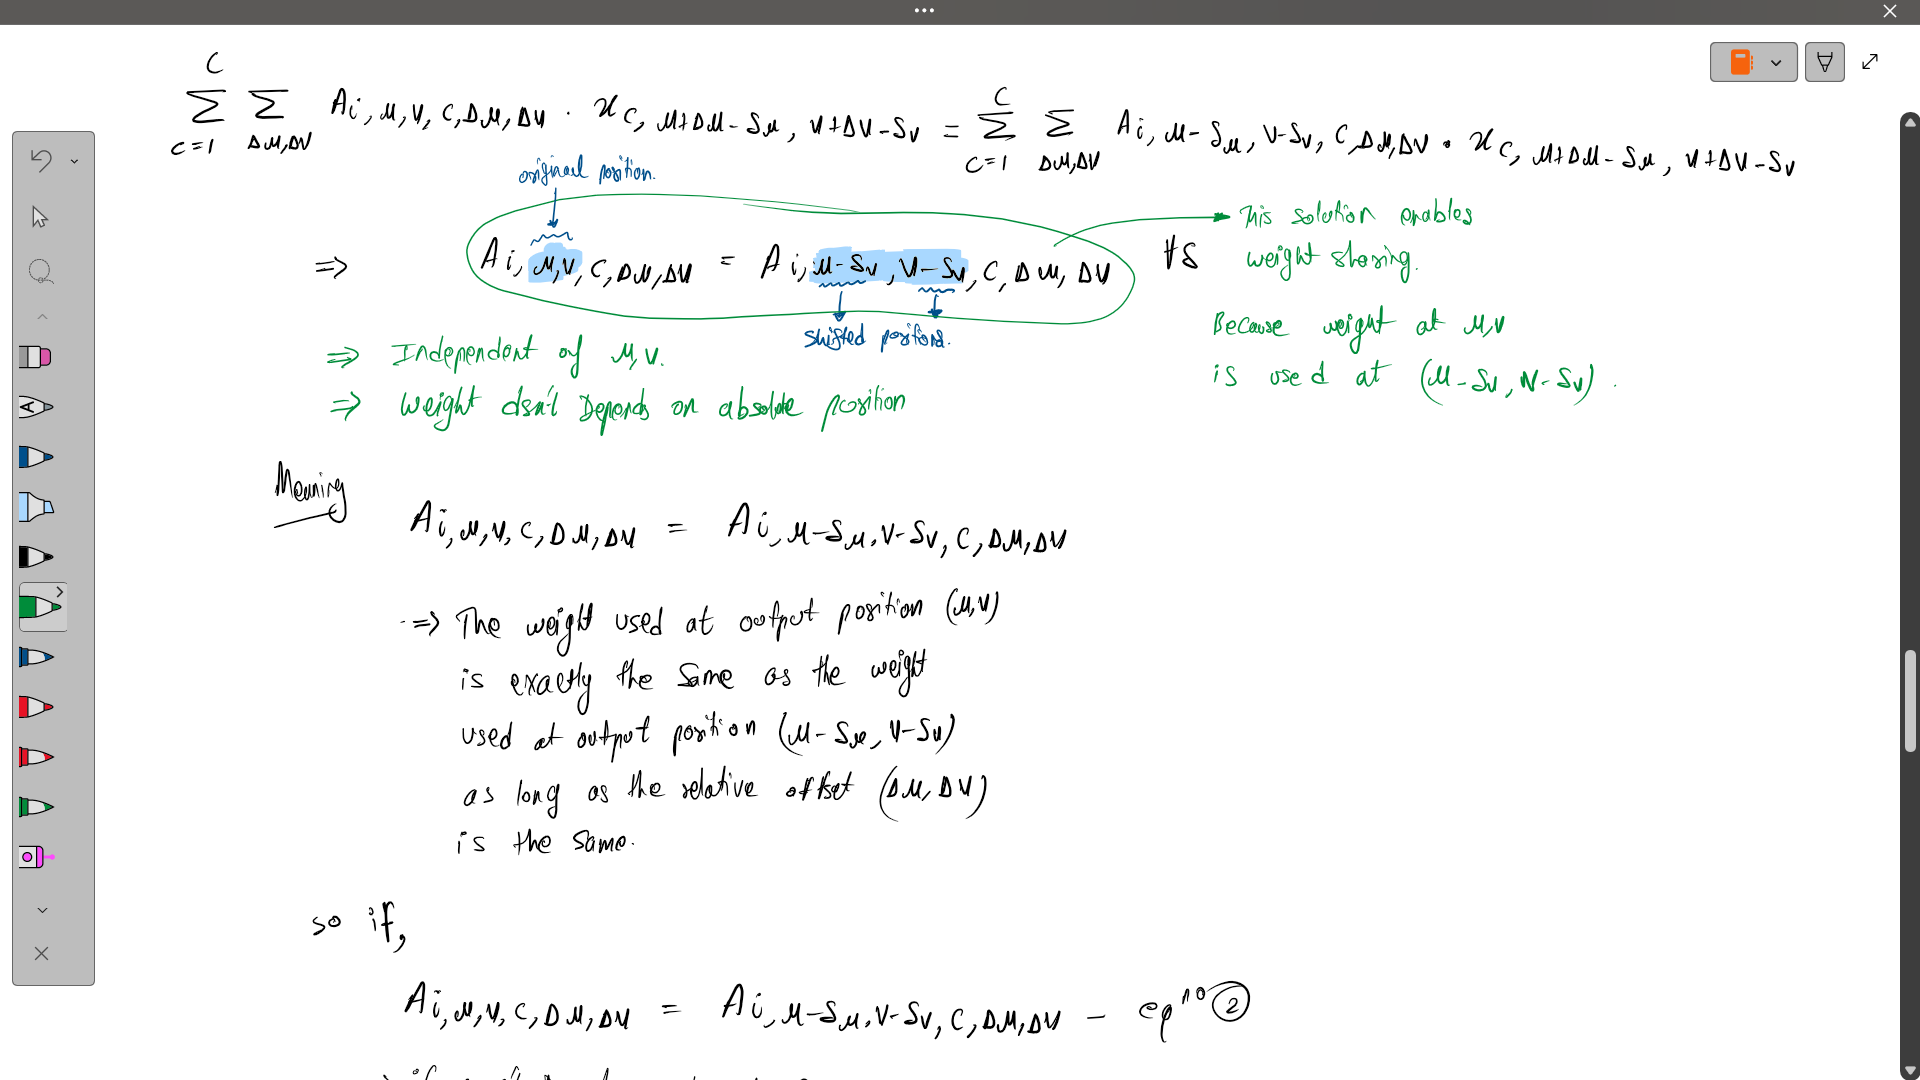

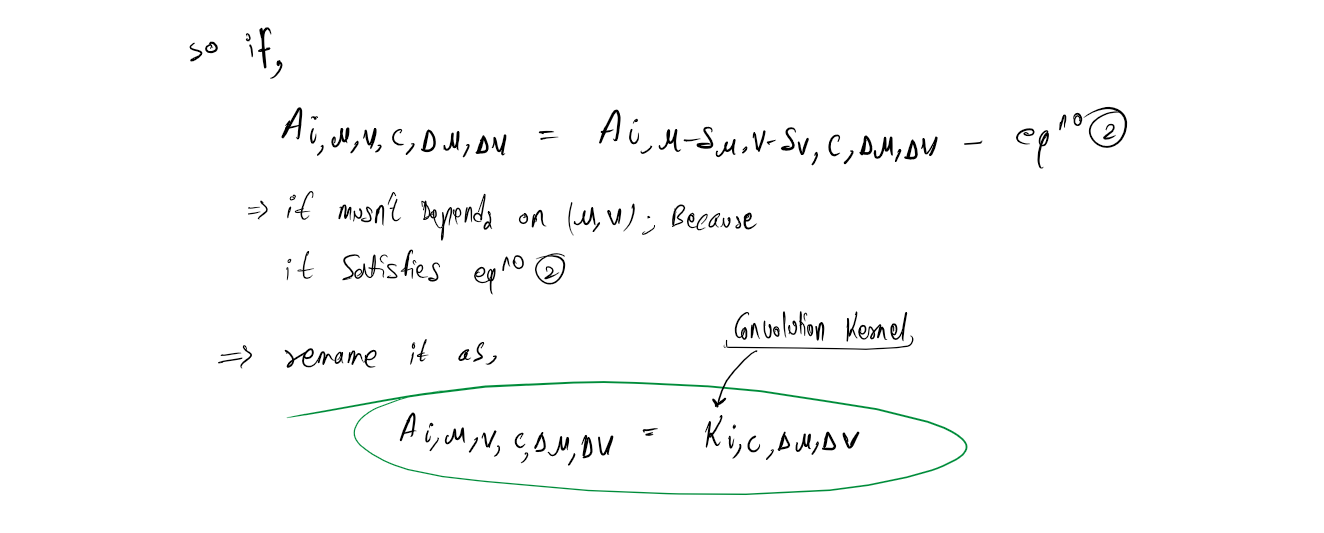

## Before V/S After

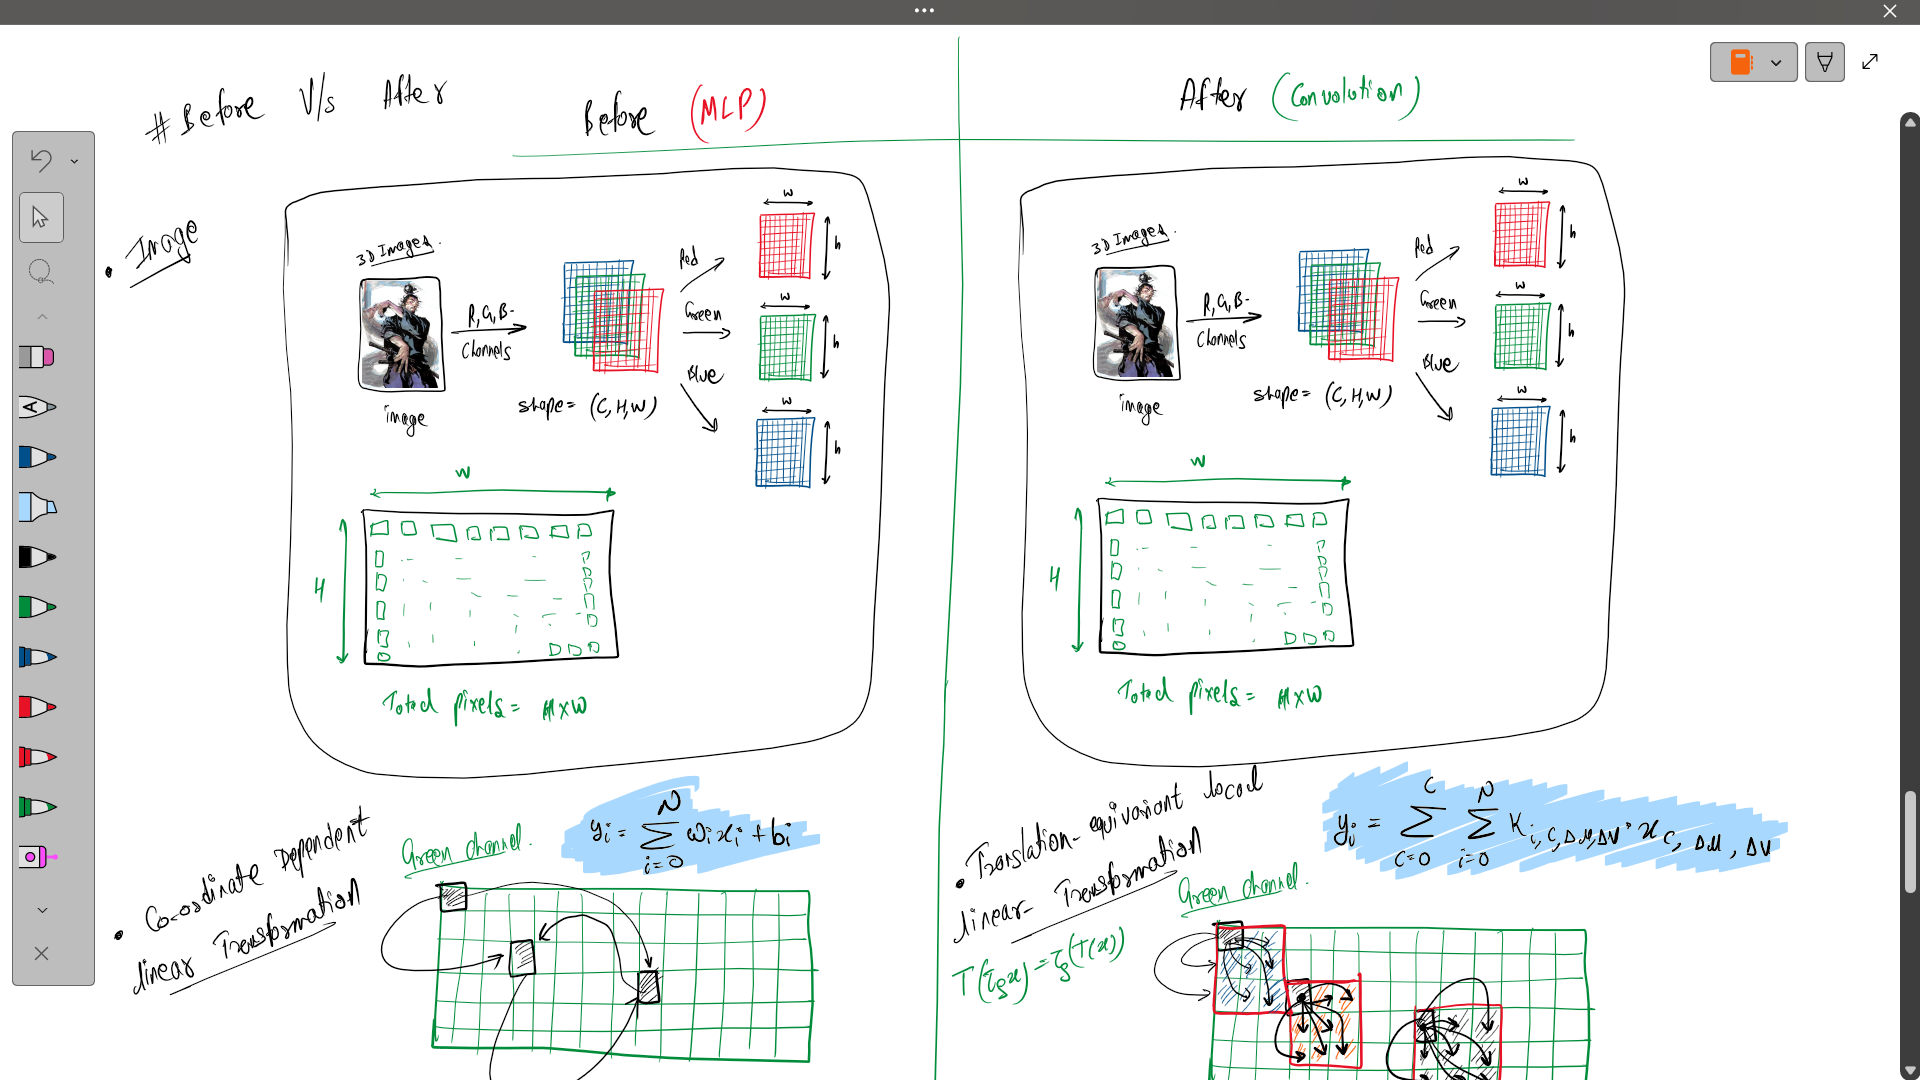

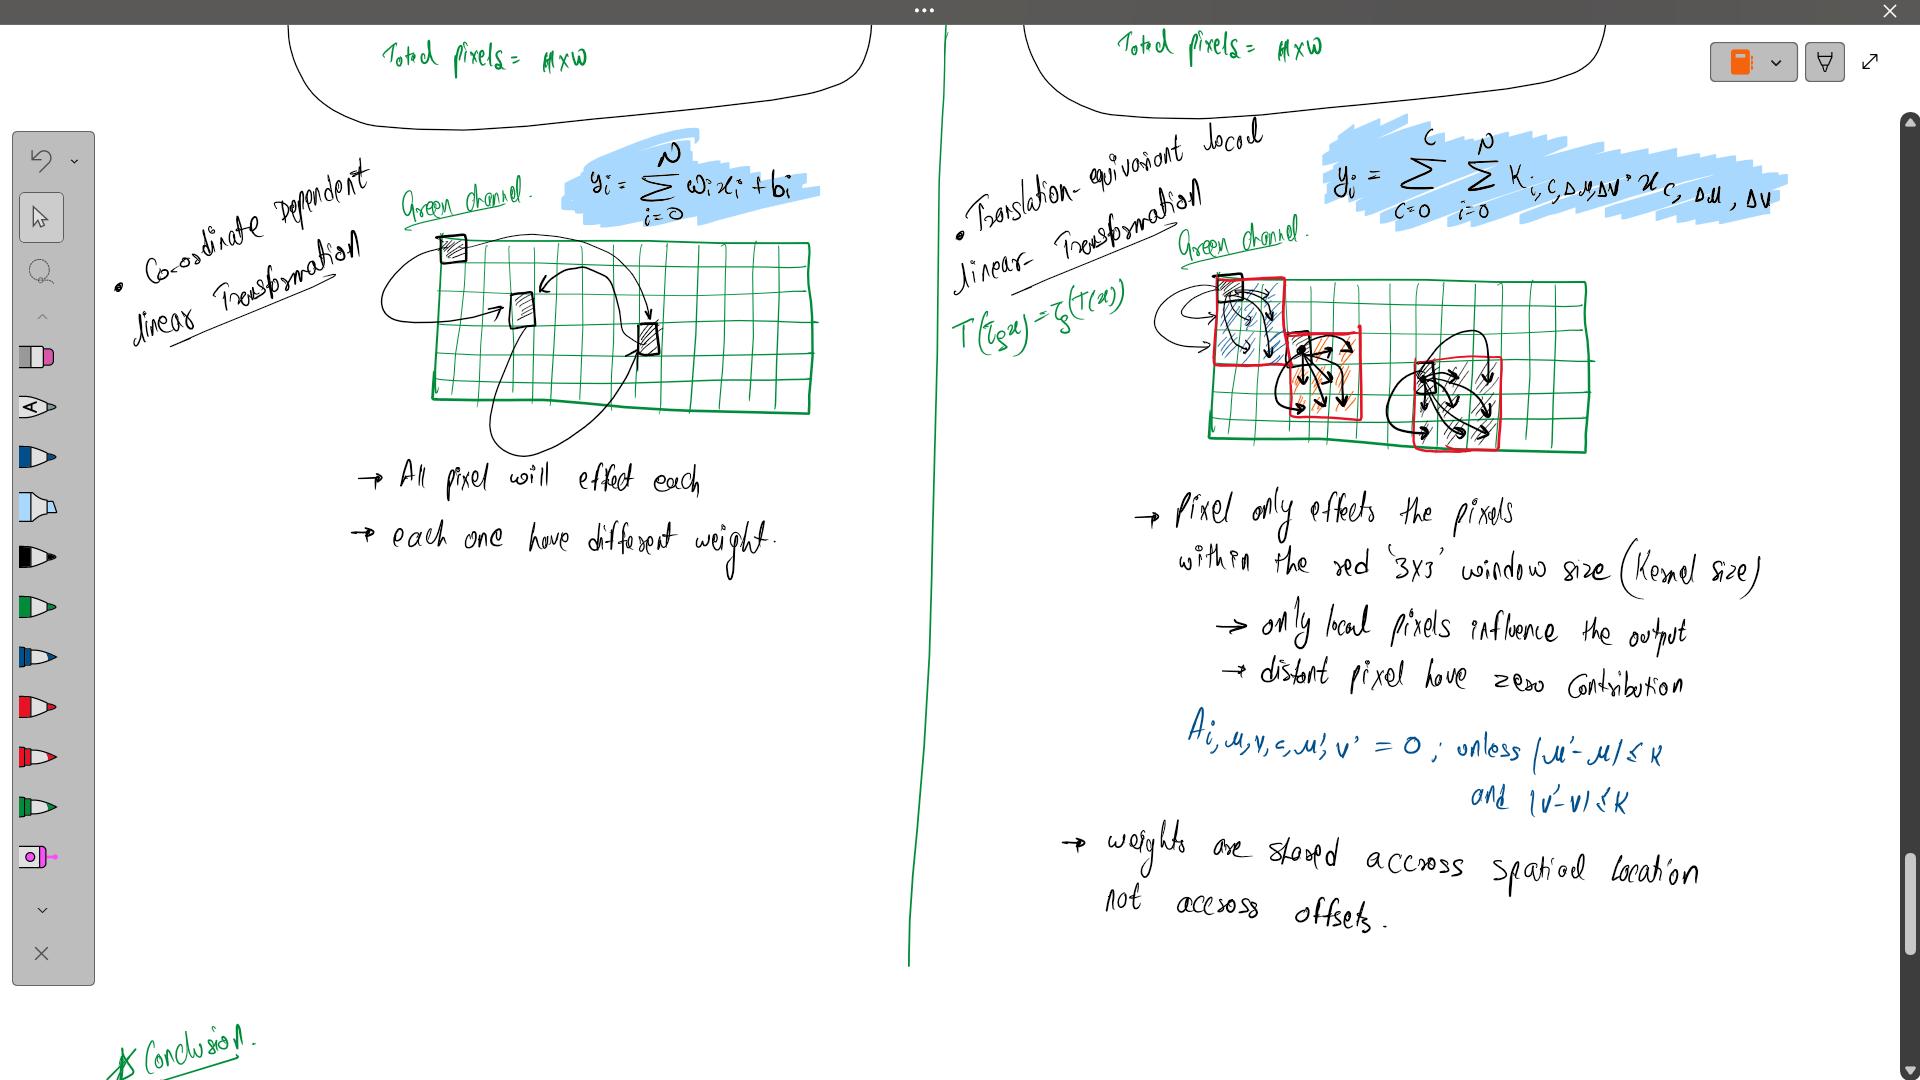

## Conclusion

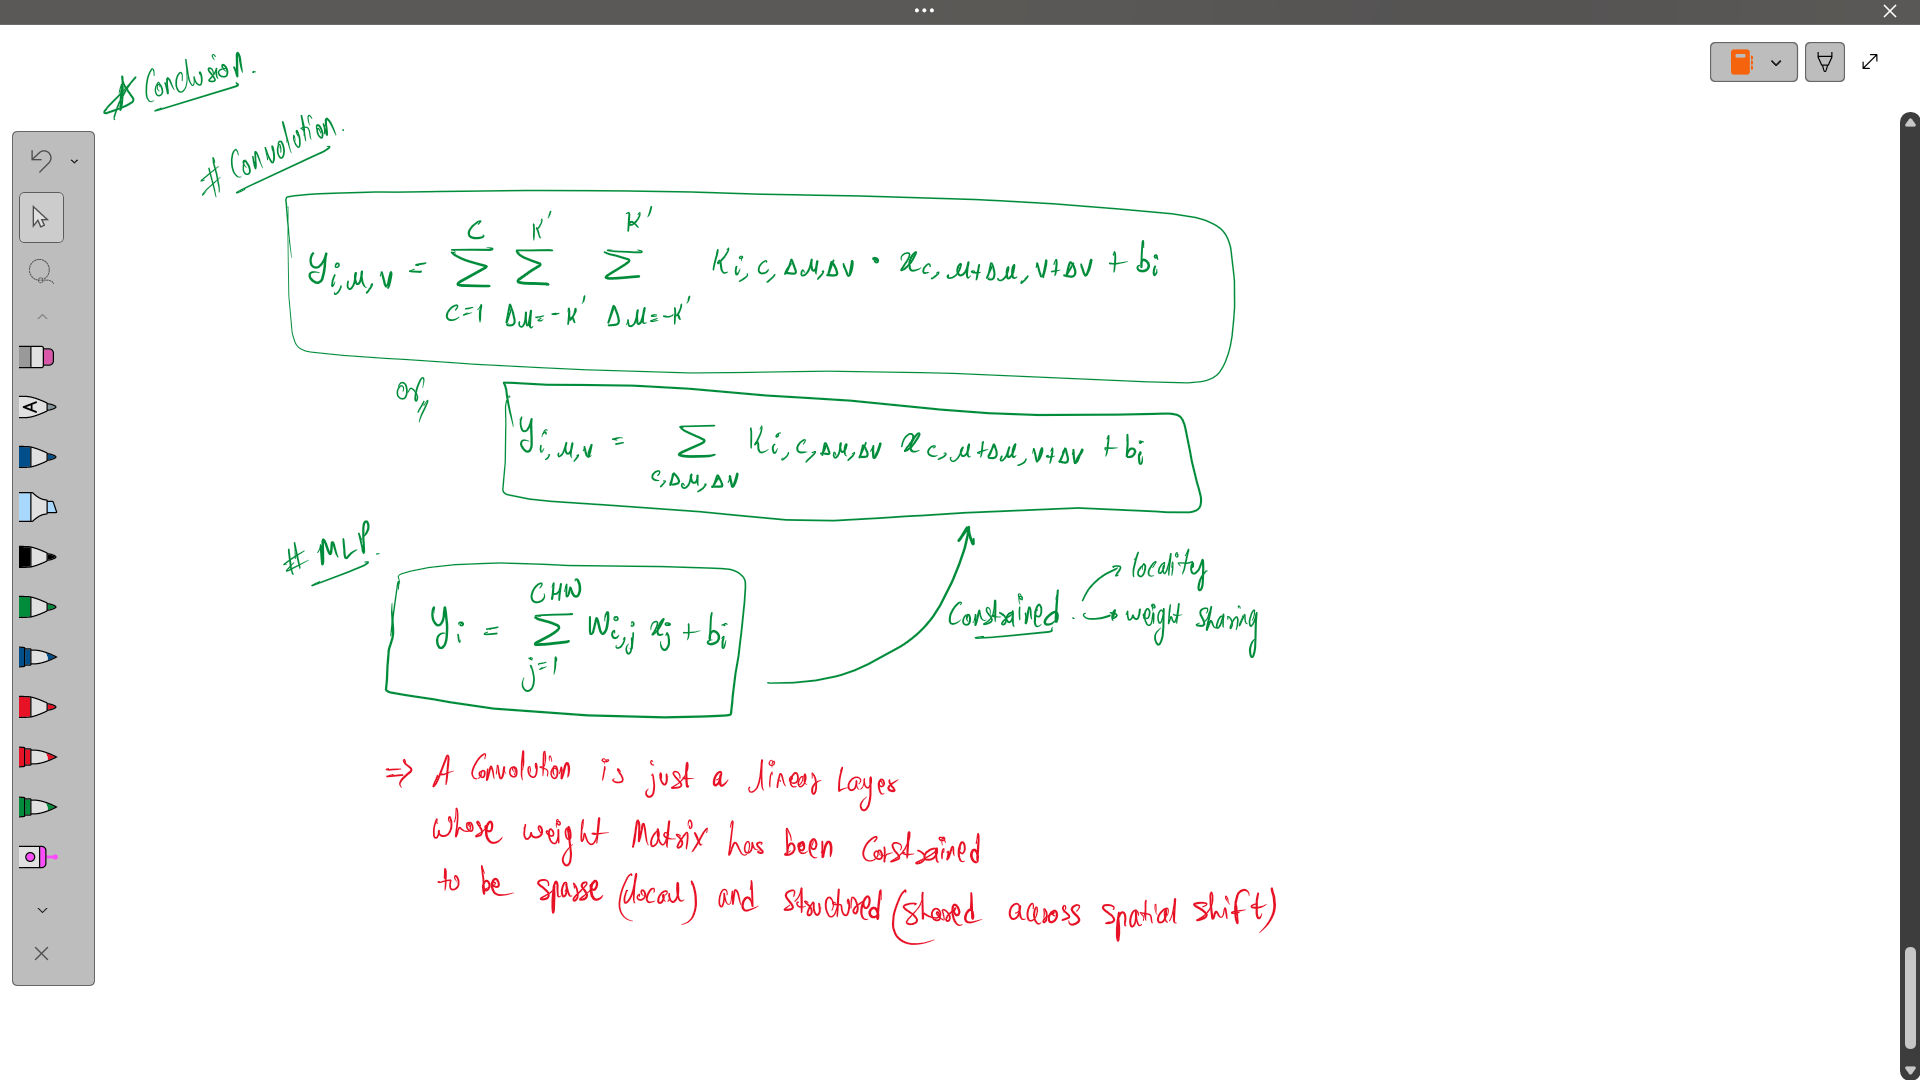

## Let's Implement this Convolution

In [1]:
# Load an Image
from PIL import Image
import torch
import torchvision.transforms as T
img = Image.open("../artifacts/dog_image_example.png")
x = T.PILToTensor()(img).to(torch.float32)
x_norm = x / 125.5 - 1.0

In [2]:
class ConvolutionLayer:
    def __init__(self, kernel_size: int, stride: int, in_channel: int, out_channels: int, proper_weight_init: bool):
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channel = in_channel
        self.out_channels = out_channels
        self.weight = torch.rand(self.out_channels, self.in_channel, self.kernel_size, self.kernel_size)
        if proper_weight_init:
            self.weight = torch.nn.init.xavier_uniform_(self.weight)
        # This means:
            # I applied self.out_channels number of independent filters
            # Each filter spans all self.in_channel number of input channels
            # Each filter produces one feature map
        self.bias = torch.zeros(self.out_channels)

    def forward(self, x: torch.tensor):
        """
        This defines the forward pass of the Convolution Linear Layer
        """
        self.output = []
        _, H, W = x.shape
        H_out = (H - self.kernel_size + 1) // self.stride
        W_out = (W - self.kernel_size + 1) // self.stride
        out = torch.zeros(self.out_channels, H_out, W_out)
        for o in range(self.out_channels):
            for i in range(0, H - self.kernel_size + 1, self.stride):
                for j in range(0, W - self.kernel_size + 1, self.stride):
                    patch = x[:, i: i + self.kernel_size, j: j + self.kernel_size]
                    y = torch.sum(self.weight[o] * patch) + self.bias[o]
                    out[o][i//self.stride, j//self.stride] = y
                
        return out
    
    def __call__(self, x: torch.tensor):
        return self.forward(x)
    

In [3]:
kernel_size = 3
stride = 1
in_channels = x_norm.shape[0]
out_channels = 5
conv_layer = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = in_channels, out_channels = out_channels, proper_weight_init = False)
output_conv = conv_layer(x_norm)

In [4]:
kernel_size = 3
stride = 1
in_channels = x_norm.shape[0]
out_channels = 5
conv_layer_1 = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = in_channels, out_channels = out_channels, proper_weight_init = False)
conv_layer_2 = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = out_channels, out_channels = out_channels, proper_weight_init = False)
z_1 = conv_layer_1(x_norm)
a_1 = torch.relu(z_1)
output_conv_v2 = conv_layer_2(a_1)

In [5]:
print(f"Before enterring the convolution layer: x.shape = {x_norm.shape}")
print(f"Output shape of the convolution layer: {output_conv.shape}")
print("> Meaning: ")
print(f"This convolution layer maps each local 3×3×3 neighborhood to a 5-dimensional feature vector, at every spatial location")

print("-" * 130)
print("                                                          Stastical Analysis")

print("\n\n\n\n")
print("*" * 130)
print("This is version-1's Analysis")
print("     > right now the model is like this: ")
print("     x (input_image_tensor (C, H, W))")
print("     → conv2d((C, H, W) → (out_channels, H_out, K_out))")
print("*" * 130)
print("Before enterring the convolution layer: ")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print()
print("After passing from the convolution layer: ")
print(f"     > output.mean() = {output_conv.mean():.4f}")
print(f"     > output.std() = {output_conv.std():.4f}")
print("\n\n\n\n")
print("*" * 130)
print("This is version-2's Analysis")
print("     > right now the model is like this: ")
print("     x (input_image_tensor (C, H, W))")
print("     → conv2d((C, H, W) → (out_channels, H_out_1, K_out_1))")
print("     → torch.relu()")
print("     → conv2d((out_channels, H_out_1, K_out_1) → (out_channels, H_out_2, K_out_2))")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print()
print("*" * 130)
print("Before enterring the convolution layer: ")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print("After passing from the convolution layers: ")
print("1st convolution layer: ")
print(f"     > z_1.mean() = {z_1.mean():.4f}")
print(f"     > z_1.std() = {z_1.std():.4f}")
print(f"After passing from relu() activation: ")
print(f"     > a_1.mean() = {a_1.mean():.4f}")
print(f"     > a_1.std() = {a_1.std():.4f}")
print("2nd convolution layer: ")
print(f"     > output_conv_v2.mean() = {output_conv_v2.mean():.4f}")
print(f"     > output_conv_v2.std() = {output_conv_v2.std():.4f}")
print("\n\n\n")
print("Note: The mean and std got exploded, because of stacked layers and the stastics are not maintained accross the layers")
print("solution: use BatchNorm/LayerNorm with Proper weigh Initialization")


print("Doing same experiment but with proper weight initialization")
print("*" * 130)

Before enterring the convolution layer: x.shape = torch.Size([3, 350, 541])
Output shape of the convolution layer: torch.Size([5, 348, 539])
> Meaning: 
This convolution layer maps each local 3×3×3 neighborhood to a 5-dimensional feature vector, at every spatial location
----------------------------------------------------------------------------------------------------------------------------------
                                                          Stastical Analysis





**********************************************************************************************************************************
This is version-1's Analysis
     > right now the model is like this: 
     x (input_image_tensor (C, H, W))
     → conv2d((C, H, W) → (out_channels, H_out, K_out))
**********************************************************************************************************************************
Before enterring the convolution layer: 
     > x.mean() = 0.0987
     > x.std() = 0.510

In [6]:
# ---------------------------------------------- v1 --------------------------------------------------------------
kernel_size = 3
stride = 1
in_channels = x_norm.shape[0]
out_channels = 5
conv_layer = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = in_channels, out_channels = out_channels, proper_weight_init = True)
output_conv = conv_layer(x_norm)

# ---------------------------------------------- v2 --------------------------------------------------------------
kernel_size = 3
stride = 1
in_channels = x_norm.shape[0]
out_channels = 5
conv_layer_1 = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = in_channels, out_channels = out_channels, proper_weight_init = True)
conv_layer_2 = ConvolutionLayer(kernel_size = kernel_size, stride = stride, in_channel = out_channels, out_channels = out_channels, proper_weight_init = True)
z_1 = conv_layer_1(x_norm)
a_1 = torch.relu(z_1)
output_conv_v2 = conv_layer_2(a_1)

In [7]:
print("Doing same experiment but with proper weight initialization")
print("\n\n\n")
print(f"Before enterring the convolution layer: x.shape = {x_norm.shape}")
print(f"Output shape of the convolution layer: {output_conv.shape}")
print("> Meaning: ")
print(f"This convolution layer maps each local 3×3×3 neighborhood to a 5-dimensional feature vector, at every spatial location")

print("-" * 130)
print("                                                          Stastical Analysis")

print("\n\n\n\n")
print("*" * 130)
print("This is version-1's Analysis")
print("     > right now the model is like this: ")
print("     x (input_image_tensor (C, H, W))")
print("     → conv2d((C, H, W) → (out_channels, H_out, K_out))")
print("*" * 130)
print("Before enterring the convolution layer: ")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print()
print("After passing from the convolution layer: ")
print(f"     > output.mean() = {output_conv.mean():.4f}")
print(f"     > output.std() = {output_conv.std():.4f}")
print("\n\n\n\n")
print("*" * 130)
print("This is version-2's Analysis")
print("     > right now the model is like this: ")
print("     x (input_image_tensor (C, H, W))")
print("     → conv2d((C, H, W) → (out_channels, H_out_1, K_out_1))")
print("     → torch.relu()")
print("     → conv2d((out_channels, H_out_1, K_out_1) → (out_channels, H_out_2, K_out_2))")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print()
print("*" * 130)
print("Before enterring the convolution layer: ")
print(f"     > x.mean() = {x_norm.mean():.4f}")
print(f"     > x.std() = {x_norm.std():.4f}")
print("After passing from the convolution layers: ")
print("1st convolution layer: ")
print(f"     > z_1.mean() = {z_1.mean():.4f}")
print(f"     > z_1.std() = {z_1.std():.4f}")
print(f"After passing from relu() activation: ")
print(f"     > a_1.mean() = {a_1.mean():.4f}")
print(f"     > a_1.std() = {a_1.std():.4f}")
print("2nd convolution layer: ")
print(f"     > output_conv_v2.mean() = {output_conv_v2.mean():.4f}")
print(f"     > output_conv_v2.std() = {output_conv_v2.std():.4f}")
print("\n\n\n")
print("Note: The mean and std are stable accross all layers, because of proper weigh Initialization")
print("Naive random initialization causes exponential signal growth in stacked conv layers.")
print("Proper variance-preserving initialization (Xavier / Kaiming) stabilizes mean and variance across layers during forward propagation.")
print("Normalization layers are not mandatory for shallow networks but become critical as depth and training dynamics increase.")
print("*" * 130)

Doing same experiment but with proper weight initialization




Before enterring the convolution layer: x.shape = torch.Size([3, 350, 541])
Output shape of the convolution layer: torch.Size([5, 348, 539])
> Meaning: 
This convolution layer maps each local 3×3×3 neighborhood to a 5-dimensional feature vector, at every spatial location
----------------------------------------------------------------------------------------------------------------------------------
                                                          Stastical Analysis





**********************************************************************************************************************************
This is version-1's Analysis
     > right now the model is like this: 
     x (input_image_tensor (C, H, W))
     → conv2d((C, H, W) → (out_channels, H_out, K_out))
**********************************************************************************************************************************
Before enterring the con

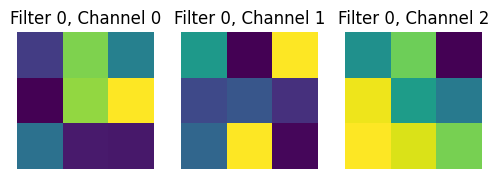

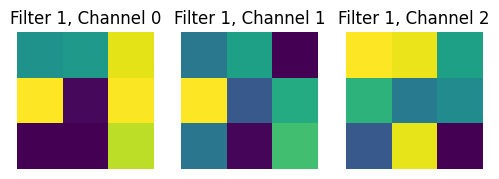

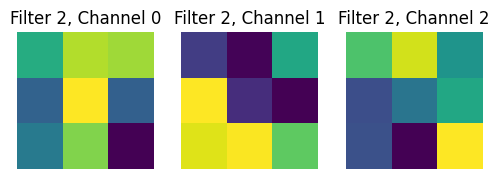

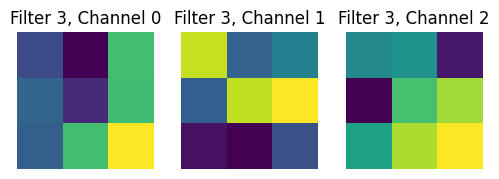

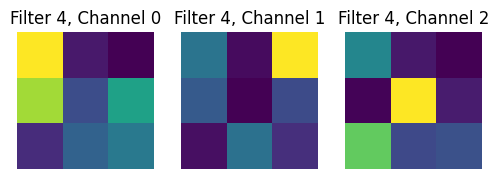

In [8]:
import matplotlib.pyplot as plt

for o in range(out_channels):
    fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    for c in range(3):
        axs[c].imshow(conv_layer_1.weight[o, c].detach().cpu(), cmap="viridis")
        axs[c].set_title(f"Filter {o}, Channel {c}")
        axs[c].axis("off")
    plt.show()


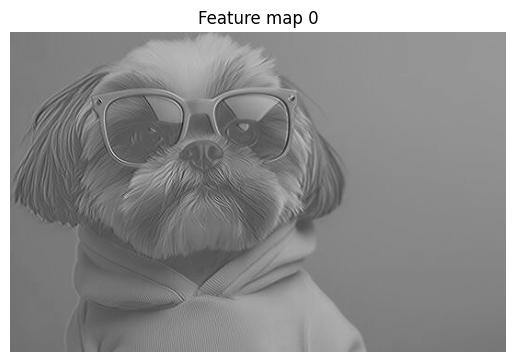

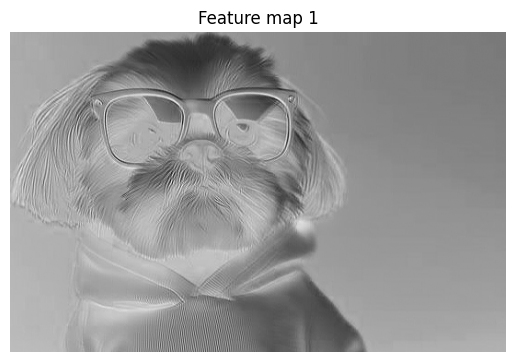

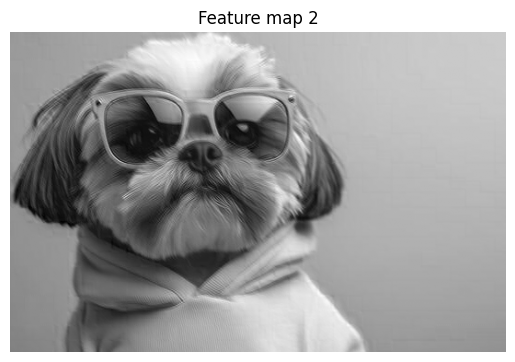

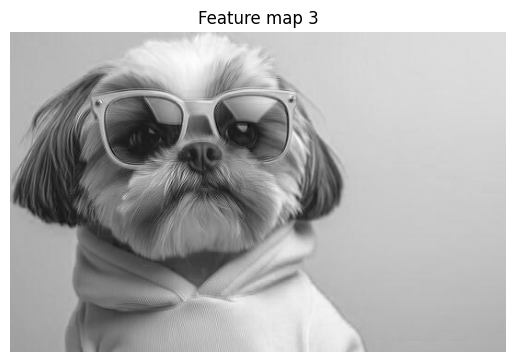

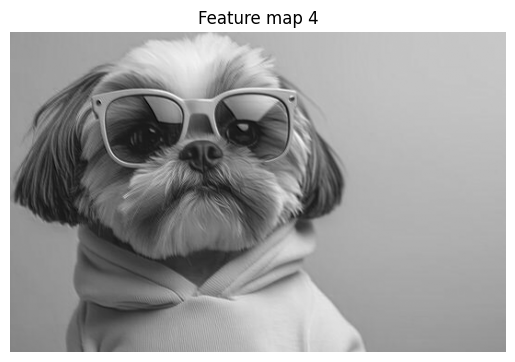

In [9]:
feature_maps = output_conv
for o in range(out_channels):
    plt.imshow(feature_maps[o].detach().cpu(), cmap="gray")
    plt.title(f"Feature map {o}")
    plt.axis("off")
    plt.show()


## Let's Implement the MaxPooling

In [10]:
class MaxPool2d:
    def __init__(self, kernel_size: int, stride: int):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x: torch.tensor):
        C, H, W = x.shape
        h_out = (H - self.kernel_size + 1) // self.stride
        w_out = (W - self.kernel_size + 1) // self.stride
        out = torch.zeros(C, h_out, w_out)
        for c in range(C):
            for i in range(0, H - self.kernel_size + 1, self.stride):
                for j in range(0, W - self.kernel_size + 1, self.stride):
                    region = x[c, i: i + self.kernel_size, j: j + self.kernel_size]
                    out[c][i//self.stride, j//self.stride] = region.max()
        return out

    def __call__(self, x: torch.tensor):
        return self.forward(x)

In [11]:
max_pooling_layer = MaxPool2d(kernel_size = 2, stride = 2)

In [17]:
def max_pool2d(x: torch.tensor, kernel_size: int, stride: int):
    H, W = x.shape
    h_out = (H - kernel_size + 1) // stride
    w_out = (W - kernel_size + 1) // stride
    out = torch.zeros(h_out, w_out)
    print("The input tensor is:\n", x)
    for i in range(0, H - kernel_size + 1, stride):
        for j in range(0, W - kernel_size + 1, stride):
            region = x[i: i + kernel_size, j: j + kernel_size]
            out[i//stride, j//stride] = torch.max(region)
    print("After performing maxpooling, the output tensor is:\n", out)
    return out

In [18]:
dummy_x = torch.randint(low = 2, high = 100, size = (9, 9)).to(torch.float32)
max_pool_output = max_pool2d(dummy_x, kernel_size = 2, stride = 2)

The input tensor is:
 tensor([[38., 93.,  6., 54., 53., 38., 42., 76., 39.],
        [46., 51., 47., 51., 17., 60., 52., 87., 72.],
        [64., 63., 88.,  8., 95., 32., 52., 32., 22.],
        [92., 54., 86., 70.,  2., 49., 61., 89., 97.],
        [13., 10., 80., 35., 49.,  5., 86., 48., 16.],
        [34., 59., 57., 96., 41., 75., 59., 72., 48.],
        [45., 87., 61., 53., 94., 61., 57., 39., 59.],
        [79., 78., 75., 73., 35., 97., 75., 31.,  3.],
        [83., 62., 21., 63., 85., 13., 35., 69., 75.]])
After performing maxpooling, the output tensor is:
 tensor([[93., 54., 60., 87.],
        [92., 88., 95., 89.],
        [59., 96., 75., 86.],
        [87., 75., 97., 75.]])


In [19]:
max_pooling_layer(dummy_x.unsqueeze(dim = 0)) == max_pool_output

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [20]:
((31 - 2) // 2 ) + 1

15

## BatchNorm

In [21]:
import torch
batch = 2
img_height = 4
img_width = 4
num_channels = 3
x = torch.rand(batch, num_channels, img_height, img_width)
in_channels = x.shape[-3]
gamma = torch.ones(in_channels)
beta = torch.zeros(in_channels)

In [22]:
mean = torch.mean(x, dim = (0, 2, 3), keepdim=True)
mean

tensor([[[[0.4904]],

         [[0.4441]],

         [[0.5112]]]])

In [23]:
x.shape # B, C, H, W -> 2 different batch of images containing 3 channels of 4x4 feature map

torch.Size([2, 3, 4, 4])

In [24]:
x[:, 0, : ,:] # This is my 1st channel containing 2 batches of same channel, we will normalize this

tensor([[[0.8942, 0.2344, 0.0899, 0.4534],
         [0.3609, 0.5798, 0.4217, 0.6703],
         [0.2848, 0.1845, 0.9581, 0.5600],
         [0.1021, 0.2733, 0.4480, 0.5884]],

        [[0.9537, 0.8095, 0.7014, 0.9266],
         [0.4999, 0.1951, 0.0671, 0.9508],
         [0.2100, 0.1611, 0.9483, 0.6159],
         [0.2432, 0.4052, 0.2581, 0.6428]]])

In [25]:
x[:, 0, : ,:].mean()

tensor(0.4904)

In [26]:
x[:, 1, : ,:].mean()

tensor(0.4441)

In [27]:
x[:, 2, : ,:].mean()

tensor(0.5112)

In [28]:
dummy_x = torch.rand(2, 3, 3)
dummy_x

tensor([[[0.0039, 0.2552, 0.3340],
         [0.3083, 0.4023, 0.7082],
         [0.9916, 0.1077, 0.2890]],

        [[0.6636, 0.1413, 0.0954],
         [0.6822, 0.2496, 0.2553],
         [0.9790, 0.3051, 0.9278]]])

In [29]:
dummy_x[0].mean(), dummy_x[1].mean()

(tensor(0.3778), tensor(0.4777))

In [30]:
max_pooling_layer = MaxPool2d(kernel_size = 3, stride = 1)
max_pooling_layer(dummy_x).squeeze()

tensor([0.9916, 0.9790])